## Calculating return period for cyclones in Mozambique

We're looking to calculate the return period for cyclones of a given threshold speed over select provinces in Mozambique. We'd like to have both: 
- An overall return period across all selected provinces
- A per-province return period

In [8]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import geopandas as gpd
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
from shapely.geometry import LineString
from datetime import datetime
import matplotlib.pyplot as plt
from src.constants import *
from src.datasources import helpers

load_dotenv()
# https://en.wikipedia.org/wiki/Tropical_cyclone_scales#South-West_Indian_Ocean

False

## 1. Data loading and preparation

We'll start by loading in the required data sources below. We need the ADM1 boundaries (provinces) and the [IBTrACS](https://www.ncei.noaa.gov/products/international-best-track-archive) `.shp` of cyclone tracks. We'll select only the provinces of interest from the admin boundaries file.

In [ ]:
adm1_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)
adm2_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)
gdf_adm1 = gpd.read_file(adm1_path)
gdf_adm2 = gpd.read_file(adm2_path)

gdf_sel = gdf_adm1[gdf_adm1.ADM1_PT.isin(ADMS)]
gdf_adm2_sel = gdf_adm2[gdf_adm2.ADM2_PT.isin(ADMS2)]
ibtracs_path = adm1_path = (
    Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
)
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
lines_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.lines/IBTrACS.SI.list.v04r01.lines.shp"
)

gdf_points = gpd.read_file(points_path)
gdf_lines = gpd.read_file(lines_path)

In [ ]:
# Some additional data shared from Tristan that might be useful
wmo_speeds_path = (
    Path(AA_DATA_DIR_NEW)
    / "public"
    / "processed"
    / "glb"
    / "ibtracs"
    / "ibtracs_with_wmo_wind.parquet"
)
df_wmo_speeds = pd.read_parquet(wmo_speeds_path)

Let's also check that both datasets have the same CRS. Then we can select only the points within the polygons. We'll also clean up the columns and make sure points are sorted by time.

In [12]:
assert gdf_points.crs == gdf_sel.crs == gdf_lines.crs
gdf_points_sel = gpd.sjoin(
    gdf_points, gdf_sel, how="inner", predicate="intersects"
)
gdf_lines_sel = gpd.sjoin(
    gdf_lines, gdf_sel, how="inner", predicate="intersects"
)
gdf_points_sel_ = gdf_points_sel[
    [
        "ADM1_PT",
        "NAME",
        "ISO_TIME",
        "REU_WIND",
        "WMO_WIND",
        "USA_WIND",
        "geometry",
    ]
].sort_values("ISO_TIME")

<Axes: >

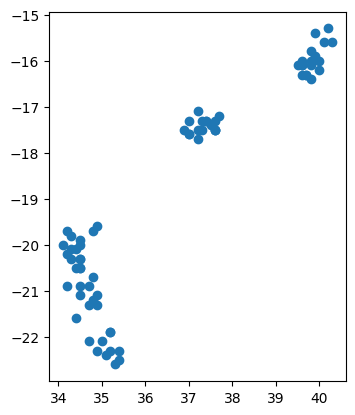

In [13]:
gdf_adm2_points = gpd.sjoin(
    gdf_points, gdf_adm2_sel, how="inner", predicate="intersects"
)
gdf_adm2_points.plot()

And plot for a basic sanity check

<Axes: >

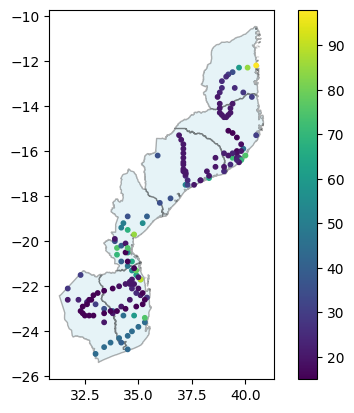

In [14]:
ax = gdf_sel.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_points_sel_.plot(ax=ax, column="REU_WIND", markersize=10, legend=True)

Now we also want to get the maximum speed per storm track. 

**TODO: Interpolate to greater temporal frequency (eg. 30 mins)**

In [15]:
lines = []
for name, group in gdf_points_sel_.groupby("NAME"):
    # TODO: Interpolate to avoid groups of only 1 point
    if len(group) > 1:
        line = LineString(group["geometry"].tolist())
        lines.append(
            {
                "NAME": name,
                "geometry": line,
                "max_speed": group["REU_WIND"].max(),
            }
        )

gdf_tracks_joined = gpd.GeoDataFrame(lines, crs="EPSG:4326")

And plot again to sanity check

<Axes: >

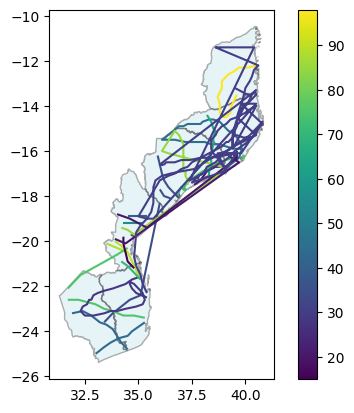

In [16]:
ax = gdf_sel.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_tracks_joined.plot(ax=ax, column="max_speed", markersize=10, legend=True)

## 2. Return period calculation

How often do storms reach 80km/hr within these provinces?

In [ ]:
# combining US Wind and REUnion for those with no wind speed
gdf_points_sel_["REU_USA_WIND"] = gdf_points_sel_["REU_WIND"].fillna(
    gdf_points_sel_["USA_WIND"] * MIN1_TO_MIN10
)
# combining US Wind and REUnion for those with no wind speed
gdf_adm2_points["REU_USA_WIND"] = gdf_adm2_points["REU_WIND"].fillna(
    gdf_adm2_points["USA_WIND"] * MIN1_TO_MIN10
)

In [18]:
df = gdf_points_sel_[
    gdf_points_sel_["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )
    >= 1998
]
df["NAME"].unique()

array(['UNNAMED', 'BELTANE', 'ASTRIDE', 'ELINE:LEONE', 'GLORIA', 'HUDAH',
       'DELFINA', 'JAPHET', 'FAVIO', 'JOKWE', 'IZILDA', 'DANDO', 'IRINA',
       'HARUNA', 'DELIWE', 'GUITO', 'HELLEN', 'CHEDZA', 'DINEO',
       'DESMOND', 'IDAI', 'KENNETH', 'CHALANE', 'ELOISE', 'GUAMBE', 'ANA',
       'GOMBE', 'JASMINE', 'FREDDY', 'FILIPO'], dtype=object)

In [19]:
df_adm2 = gdf_adm2_points[
    gdf_adm2_points["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )
    >= 1980
]
df_adm2["NAME"].unique()

array(['ELECTRE', 'LISETTE', 'UNNAMED', 'ELINE:LEONE', 'DELFINA',
       'JAPHET', 'FAVIO', 'JOKWE', 'IZILDA', 'DELIWE', 'HELLEN', 'CHEDZA',
       'DESMOND', 'IDAI', 'ELOISE', 'GUAMBE', 'JASMINE', 'FREDDY'],
      dtype=object)

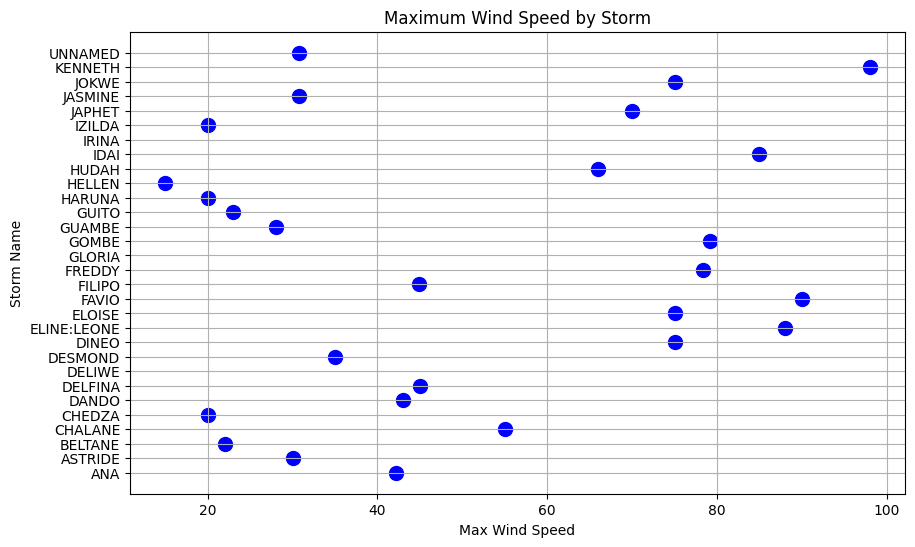

In [20]:
max_values = df.groupby("NAME")["REU_USA_WIND"].max().reset_index()

# Step 3: Plot the maximum values as points for each category
plt.figure(figsize=(10, 6))
plt.scatter(
    max_values["REU_USA_WIND"],
    max_values["NAME"],
    color="blue",
    s=100,
    label="Max Wind Speed",
)

# Adding labels and title
plt.ylabel("Storm Name")
plt.xlabel("Max Wind Speed")
plt.title("Maximum Wind Speed by Storm")
plt.grid(True)
plt.show()

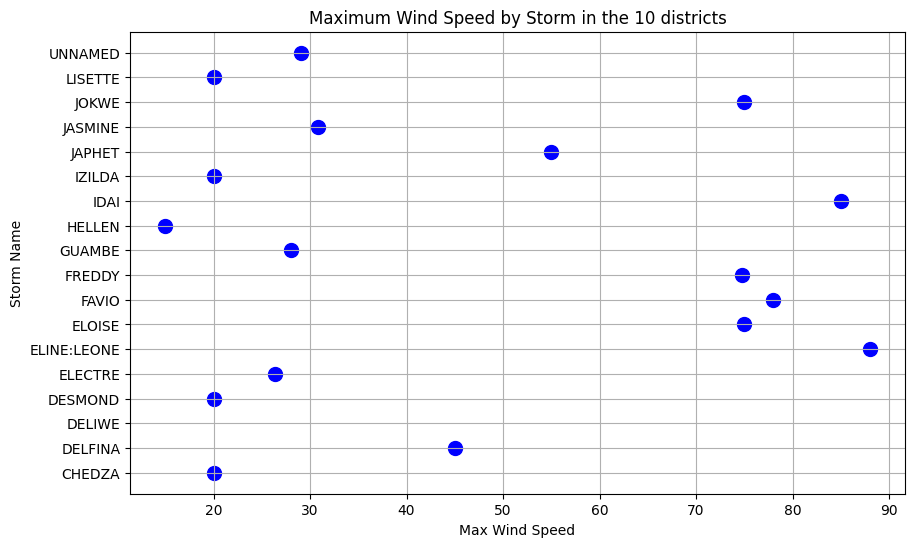

In [21]:
max_values = df_adm2.groupby("NAME")["REU_USA_WIND"].max().reset_index()

# Step 3: Plot the maximum values as points for each category
plt.figure(figsize=(10, 6))
plt.scatter(
    max_values["REU_USA_WIND"],
    max_values["NAME"],
    color="blue",
    s=100,
    label="Max Wind Speed",
)

# Adding labels and title
plt.ylabel("Storm Name")
plt.xlabel("Max Wind Speed")
plt.title("Maximum Wind Speed by Storm in the 10 districts")
plt.grid(True)
plt.show()

In [ ]:
helpers.calculate_storm_return_period(
    gdf_points_sel_, THRESHOLD_SPEED_OPT1, 1980, 1
)

The combined return period of storms over 89km/h is 1-in-2.9 years.
Probability of 1 or more storms occurring in any given year is 0.2461.


In [ ]:
helpers.calculate_storm_return_period(
    gdf_points_sel_, THRESHOLD_SPEED_OPT2, 1980, 1
)

The combined return period of storms over 118km/h is 1-in-3.3 years.
Probability of 1 or more storms occurring in any given year is 0.2234.


In [ ]:
helpers.calculate_storm_return_period(
    gdf_adm2_points,
    THRESHOLD_SPEED_OPT1,
    1980,
    1,
)

The combined return period of storms over 89km/h is 1-in-6.1 years.
Probability of 1 or more storms occurring in any given year is 0.1383.


In [ ]:
helpers.calculate_storm_return_period(
    df=gdf_adm2_points,
    wind_speed_kmh=THRESHOLD_SPEED_OPT2,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118km/h is 1-in-7.2 years.
Probability of 1 or more storms occurring in any given year is 0.1214.


## Looking at the historical impact of cyclones

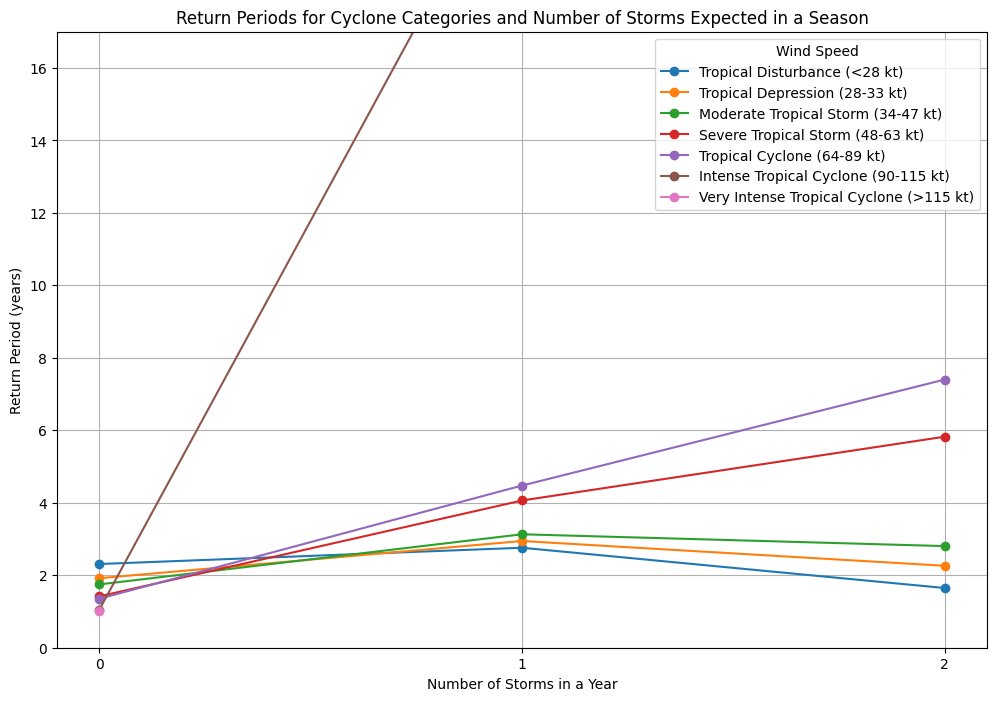

In [ ]:
# Define parameters
wind_speeds = [1, 51, 63, 89, 118, 166, 212]  # List of wind speeds in km/h
storm_numbers = range(0, 3)  # Number of storms
start_year = 1980

# Prepare to plot
plt.figure(figsize=(12, 8))

# Calculate and plot return periods for each wind speed
for wind_speed in wind_speeds:
    return_periods = []
    for storm_num in storm_numbers:
        expected_probability = helpers.calculate_storm_expected_probability(
            df=gdf_points_sel_,
            wind_speed_kmh=wind_speed,
            start_year=start_year,
            num_storms_year=storm_num,
        )

        # Calculate return period from expected probability
        if expected_probability > 0:
            return_period = 1 / expected_probability
        else:
            return_period = float(
                "inf"
            )  # Handle case where probability is zero

        return_periods.append(return_period)
    label = wind_speed_categories.get(
        wind_speed, f"{wind_speed} km/h"
    )
    plt.plot(storm_numbers, return_periods, marker="o", label=label)

# Add plot details
plt.xlabel("Number of Storms in a Year")
plt.ylabel("Return Period (years)")
plt.ylim(0, 17)
plt.title(
    "Return Periods for Cyclone Categories and Number of Storms Expected in a Season"
)
plt.legend(title="Wind Speed")
plt.xticks(ticks=range(min(storm_numbers), max(storm_numbers) + 1))

plt.grid(True)
plt.show()